## 1. Import dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Zaimportuj dane

ds_salaries = pd.read_csv('ds_salaries.csv')
ds_salaries

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [3]:
print(f"There is {ds_salaries.shape[0]} rows and {ds_salaries.shape[1]} columns")


There is 3755 rows and 11 columns


In [4]:
ds_salaries.info()

print(f'\nDataset have zero null values')
print(f'\nThere are 6 categorical columns that are worth mentioning:')
print(f'experience_level, employment_type, job_title, employee_residence, company_location and company_size)')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB

Dataset have zero null values

There are 6 categorical columns that are worth mentioning:
experience_level, employment_type, job_title, employee_residence, company_location and company_size)


## 2. Initial analysis

In [63]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

### 2.1. Categorical columns

#### 2.1.1. Experience_level

In [6]:
print(f'There is {len(ds_salaries["experience_level"].unique())} unique values in this columns')
print('Those are:')
print('EN, which refers to Entry-level')
print('MI, which refers to Mid-level')
print('SE, which refers to Senior-level')
print('EX, which refers to Executive-level')


There is 4 unique values in this columns
Those are:
EN, which refers to Entry-level
MI, which refers to Mid-level
SE, which refers to Senior-level
EX, which refers to Executive-level


In [7]:
print("Let's replace that short names with proper values")

ds_salaries['experience_level'] = ds_salaries['experience_level'].replace({
        'EN': 'Entry-level',
        'MI': 'Mid-level',
        'SE': 'Senior-level',
        'EX': 'Executive-level'
    })

Let's replace that short names with proper values


And now check how distribution look like


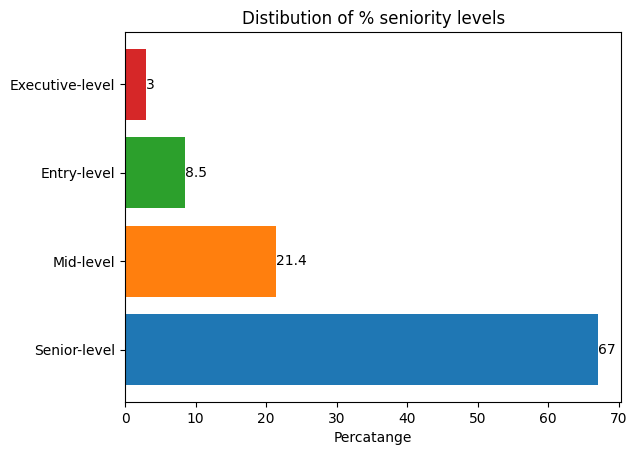

In [65]:
print('And now check how distribution look like')

level_count = ds_salaries['experience_level'].value_counts()
level_values = [level_count[i] / sum(level_count) for i in range(len(level_count))]

fig, ax = plt.subplots()

for i, level in enumerate(level_count.index):
    rects = ax.barh(level, round(level_values[i]*100, 1), label=level)

    ax.bar_label(rects)

ax.set_xlabel('Percatange')
ax.set_title('Distibution of % seniority levels')

plt.show()

#### 2.1.2. Employment_type

In [9]:
print(f'There is {len(ds_salaries["employment_type"].unique())} unique values in this columns')
print('Those are:')
print('FT - Full-time')
print('CT - Contract')
print('FL - Freelance')
print('PT - Part-time')

There is 4 unique values in this columns
Those are:
FT - Full-time
CT - Contract
FL - Freelance
PT - Part-time


In [10]:
print("Let's replace that short names with proper values")

ds_salaries['employment_type'] = ds_salaries['employment_type'].replace({
        'FT': 'Full-time',
        'CT': 'Contract',
        'FL': 'Freelance',
        'PT': 'Part-time'
    })

Let's replace that short names with proper values


And now check how the distrubtion look like
Full-time    3718
Part-time      17
Contract       10
Freelance      10
Name: employment_type, dtype: int64


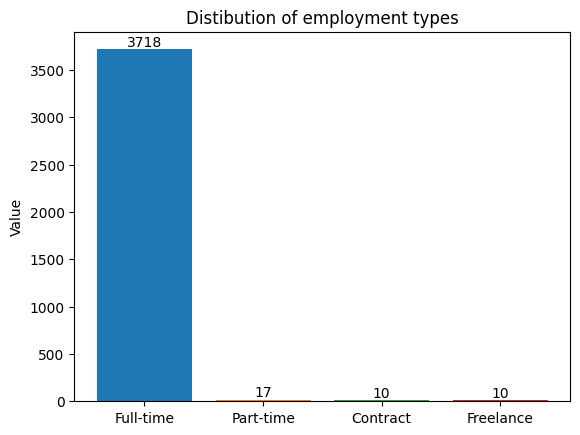

Well...
One category is defiinetely the most popular option


In [68]:
print("And now check how the distrubtion look like")

empl_type = ds_salaries['employment_type'].value_counts()
empl_values = [empl_type[i] for i in range(len(empl_type))]

fig, ax = plt.subplots()

for i, empl in enumerate(empl_type.index):
    temp = ax.bar(empl, empl_values[i], label=empl)

    ax.bar_label(temp)

ax.set_ylabel('Value')
ax.set_title('Distibution of employment types')

plt.show()

print("Well...")
print("One category is defiinetely the most popular option")

#### 2.1.3 Job_title

In [12]:
print(f"There is {len(ds_salaries['job_title'].unique())} unique values in this column")
print("That's a lot, so I will be focusing on the most important values")
print("But first let's find what are those values")

ds_salaries['job_title'] = ds_salaries['job_title'].replace('ML Engineer', 'Machine Learning Engineer')

There is 93 unique values in this column
That's a lot, so I will be focusing on the most important values
But first let's find what are those values


C:\Users\Stasiek\AppData\Local\Temp\ipykernel_15548\3790299104.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\Stasiek\AppData\Local\Temp\ipykernel_15548\3790299104.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



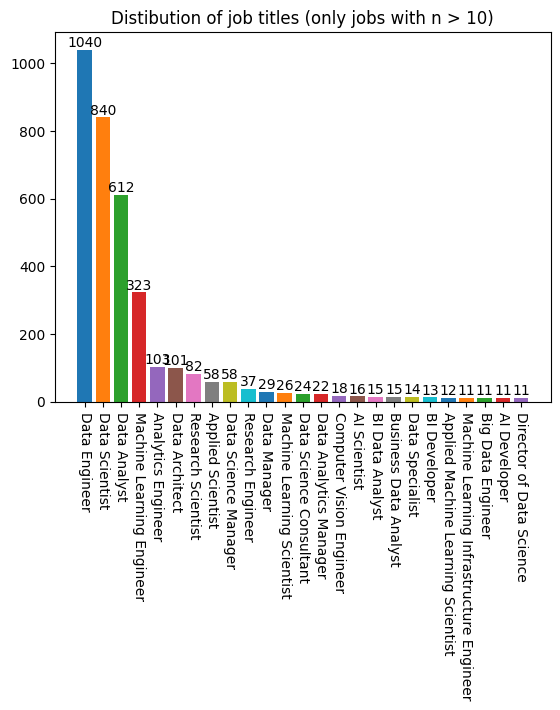

In [69]:
titles = ds_salaries['job_title'].value_counts()
titles_short = titles[titles > 10]
values = titles_short.to_list()

fig, ax = plt.subplots()

base_color = plt.cm.get_cmap('Blues')
colors = [base_color(i / len(titles_short)) for i in range(len(titles_short))]

for i, title in enumerate(titles_short.index):
    temp = ax.bar(title, values[i], label=title)
    ax.bar_label(temp)

ax.set_title('Distibution of job titles (only jobs with n > 10)')
ax.set_xticklabels(labels=titles_short.index, rotation=-90)

plt.show()

#### 2.1.4. Company_size

In [14]:
print("For company_size columns distinct values look like this:")
print("S - less than 50 employees")
print("M - from 50 to 250 employees")
print("L - more than 250 employees")

For company_size columns distinct values look like this:
S - less than 50 employees
M - from 50 to 250 employees
L - more than 250 employees


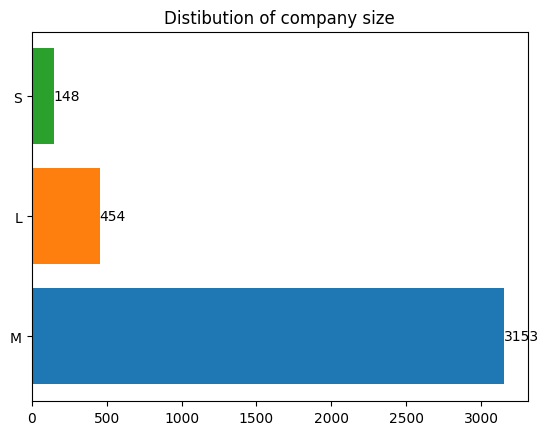

In [71]:
sizes = ds_salaries['company_size'].value_counts()
values = sizes.to_list()

fig, ax = plt.subplots()

for i, size in enumerate(sizes.index):
    temp = ax.barh(size, values[i], label=size)
    ax.bar_label(temp)

ax.set_title('Distibution of company size')

plt.show()

### 2.2. Numerical columns

#### 2.2.1. Work_year

In [16]:
print("In work_year column there are data from 2020 to 2023")

In work_year column there are data from 2020 to 2023


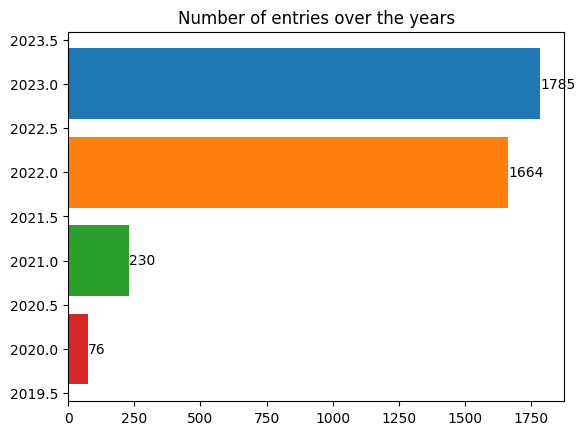

In [73]:
years = ds_salaries['work_year'].value_counts()
values = years.to_list()

fig, ax = plt.subplots()

for i, year in enumerate(years.index):
    temp = ax.barh(year, values[i], label=year)
    ax.bar_label(temp)

ax.set_title("Number of entries over the years")

plt.show()

#### 2.2.2. Salary_in_usd

In [18]:
print("This column have a lot different values, so I want to present them differently")
print("Let's use pandas describe")

ds_salaries['salary_in_usd'].describe()

This column have a lot different values, so I want to present them differently
Let's use pandas describe


count      3755.000000
mean     137570.389880
std       63055.625278
min        5132.000000
25%       95000.000000
50%      135000.000000
75%      175000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64

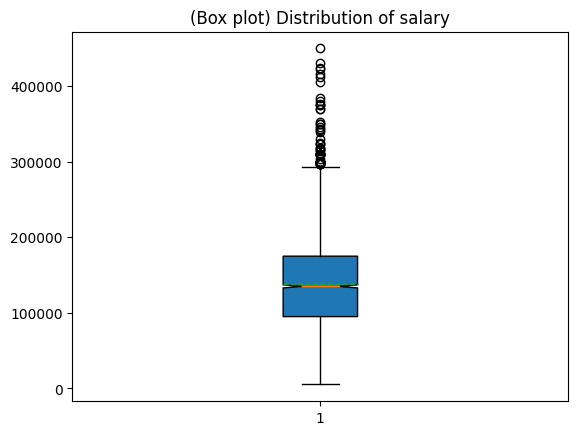

In [78]:
salary_values = ds_salaries['salary_in_usd']

fig, ax = plt.subplots()

ax.boxplot(salary_values, patch_artist=True, notch=True, showmeans=True, meanline=True)
ax.set_title("(Box plot) Distribution of salary")

plt.show()

c:\Users\Stasiek\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



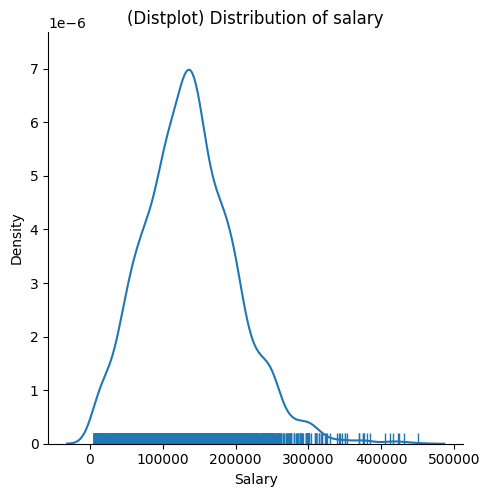

In [88]:
g = sns.displot(data=salary_values, kind='kde', rug=True)
g = g.set_xlabels("Salary")
g = g.set(title="(Distplot) Distribution of salary")

#### 2.2.3. Remote_ratio

In [21]:
print("This column is unordynary, because It contains numeric data (100, 50, 0), but they are no continous")
print("So I decided to change them to more naturall type")
print("100 - Remote")
print("50 - Hybrid")
print("0 - On-site")

ds_salaries['remote_ratio'] = ds_salaries['remote_ratio'].replace({100: 'Remote', 0:'On-site', 50:'Hybrid'})

This column is unordynary, because It contains numeric data (100, 50, 0), but they are no continous
So I decided to change them to more naturall type
100 - Remote
50 - Hybrid
0 - On-site


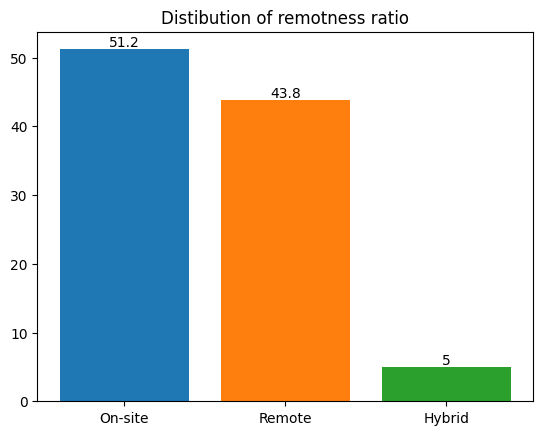

In [89]:
ratios = ds_salaries['remote_ratio'].value_counts()
values = [ratios[i] / sum(ratios) for i in range(len(ratios))]

fig, ax = plt.subplots()

for i, ratio in enumerate(ratios.index):
    temp = ax.bar(ratio, round(values[i]*100, 1), label=ratio)
    ax.bar_label(temp)

ax.set_title('Distibution of remotness ratio')

plt.show()

## 3. Experience level analysis

### 3.1. Experience level by work year

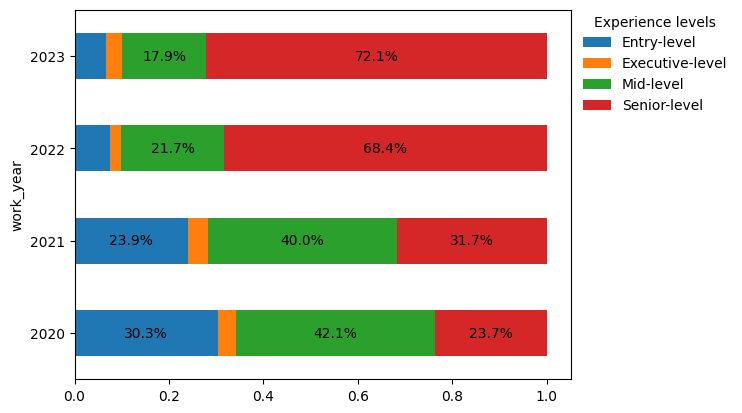

In [23]:
year_group = ds_salaries.groupby('work_year')['experience_level'].value_counts(normalize=True).unstack('experience_level')

plot = year_group.plot.barh(stacked=True)

plt.legend(title="Experience levels", frameon=False, bbox_to_anchor=(1, 1.02))

for ix, row in year_group.reset_index(drop=True).iterrows():
        cumulative = 0
        for element in row:
            if element == element and element > 0.1:
                plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{round(element * 100, 1)}%",
                    va="center",
                    ha="center",
                )
            cumulative += element

#### Conlusion

Over the year, required experience level is increasing and companies are less willing to hire juniors. This is in-line with the news that it's really hard to find entry level jobs

### 3.2. Experience level by job title

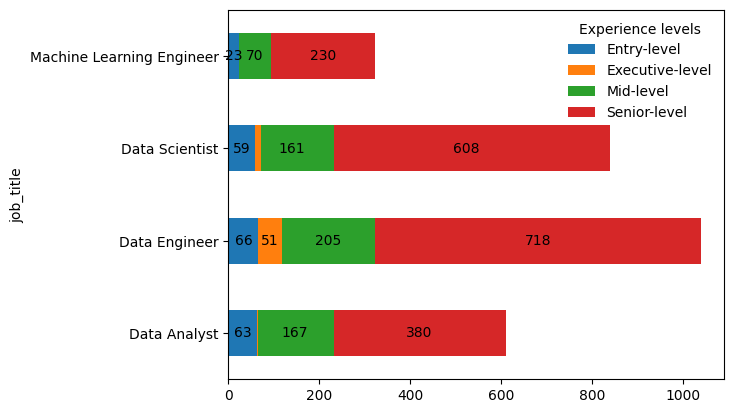

In [24]:
job_group = ds_salaries.groupby('job_title')['experience_level'].value_counts()

idx_job = ds_salaries['job_title'].unique().tolist()

for i, job in enumerate(idx_job):
    job_sum = sum(job_group.loc[job, :])
    if job_sum < 200:
        job_group.drop((job), inplace=True)

job_group = job_group.unstack('experience_level')

job_group.plot.barh(stacked=True)
plt.legend(title="Experience levels", frameon=False)

for ix, row in job_group.reset_index(drop=True).iterrows():
        cumulative = 0
        for element in row:
            if element and element > 20:
                plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element)}",
                    va="center",
                    ha="center",
                )
                cumulative += element
    

#### Conclusion

1) Senior Data Engieers are position with the biggest number of jobs, but Senior Data Scientist are just behind. 
2) There is only little difference in Entry-level position across the most popular job types
3) ML Engineers and Data Anlysist jobs have small numbers of Executive-level positions. However ML Engineers jobs are quite new, so in the future there might be a difference

### 3.3. Experience level by employment type

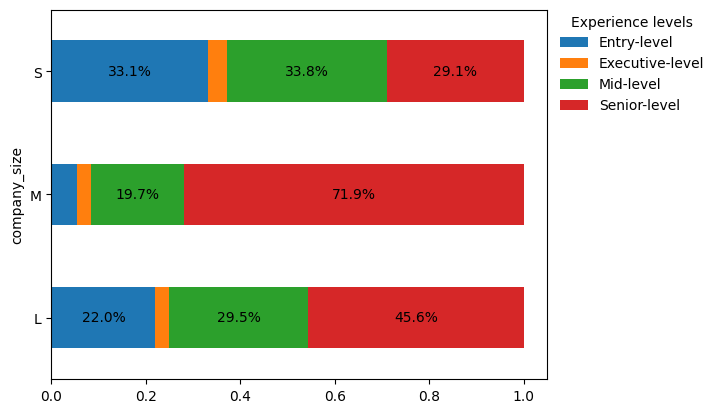

In [25]:
empl_group = ds_salaries.groupby("company_size")['experience_level'].value_counts(normalize=True).unstack('experience_level')
idx_empl = ds_salaries['employment_type'].unique().tolist()

empl_group.plot.barh(stacked=True)

plt.legend(title="Experience levels", frameon=False, bbox_to_anchor=(1, 1.02))

for ix, row in empl_group.reset_index(drop=True).iterrows():
        cumulative = 0
        for element in row:
            if element == element and element > 0.1:
                plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{round(element * 100, 1)}%",
                    va="center",
                    ha="center",
                )
            cumulative += element

#### Conlusion

1) Senior-level workers are most needed in medium size companies (72%). The smallest percentage of this level jobs are in small size companies (29%)
2) The biggest percetange of entry-level jobs are in small sized companies. The reason for this might be a smaller budget

## 4. Salary analysis

### 4.1. Salary by work year

In [26]:
object_columns = ds_salaries.select_dtypes(include=['object']).columns

print(f'W zbiorze danych jest {len(object_columns)} kolumn o typie innej niż liczbowy')

W zbiorze danych jest 8 kolumn o typie innej niż liczbowy


In [27]:
for col in object_columns:
    print(f'Kolumna {col} ma {len(ds_salaries[col].unique())} różnych wartości')

Kolumna experience_level ma 4 różnych wartości
Kolumna employment_type ma 4 różnych wartości
Kolumna job_title ma 92 różnych wartości
Kolumna salary_currency ma 20 różnych wartości
Kolumna employee_residence ma 78 różnych wartości
Kolumna remote_ratio ma 3 różnych wartości
Kolumna company_location ma 72 różnych wartości
Kolumna company_size ma 3 różnych wartości


## 2. Dostosowanie kolumn nieliczbowych

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
data = ds_salaries.copy()

data_obj = data[object_columns]

labelEncoder = LabelEncoder()

for col in object_columns:
    data[col] = labelEncoder.fit_transform(data[col])

print("Zdecydowałem się na użycie LabelEncodera, ponieważ przy zbiór danych ma kilka kolumn nienumerycznych, które mają sporo różnych wartości.")
print("Niestety nie mają one teraz wartości 0-1, dlatego będzie konieczne przesklawoanie tych wartości")

Zdecydowałem się na użycie LabelEncodera, ponieważ przy zbiór danych ma kilka kolumn nienumerycznych, które mają sporo różnych wartości.
Niestety nie mają one teraz wartości 0-1, dlatego będzie konieczne przesklawoanie tych wartości


## 3. Podział danych i ich skalowanie

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline

In [31]:
y = data['salary_in_usd']
X = data.drop('salary_in_usd', axis=1)  #To tworzy kopię data i dopiero wtedy usuwa kolumnę, więc oryginalna data jest nietknięta

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
preprocessing_pipeline = make_pipeline(
    MinMaxScaler(),
)

print("Ten potok pozwala na przeskalowanie wartości do zakresu <0; 1> przy pomocy metody MinMaxScaler")

Ten potok pozwala na przeskalowanie wartości do zakresu <0; 1> przy pomocy metody MinMaxScaler


## 4. DecisionTreeClassifier

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [34]:
dtc_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('classification', DecisionTreeClassifier())
])

In [35]:
dtc_params = {
    'classification__criterion':['gini','entropy'],
    'classification__max_depth':np.arange(1, 21).tolist()[0::2],
    'classification__min_samples_split':np.arange(2,11).tolist()[0::2],
    'classification__max_leaf_nodes':np.arange(3,501).tolist()[0::2]
}

In [36]:
r1 = RandomizedSearchCV(dtc_pipeline, dtc_params, cv=5, n_iter=100, random_state=42)

In [37]:
# r1.fit(X_train, y_train)

In [38]:
# r1.best_params_

In [39]:
# r1.score(X_test, y_test)

In [40]:
# y_pred = r1.predict(X_test)

# print(f'Accuracy score: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
# print(f'Precyzja: {precision_score(y_true=y_test, y_pred=y_pred, average="weighted")}')
# print(f'Czułość: {recall_score(y_true=y_test, y_pred=y_pred, average="weighted")}')

## 5. RandomForestRegressor

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
rfr_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('classification', RandomForestRegressor())
])

In [43]:
rfr_params = {
    'classification__n_estimators':np.arange(80, 111).tolist()[0::2],
    'classification__criterion':['squared_error','absolute_error', 'friedman_mse', 'poisson'],
    'classification__max_depth':np.arange(10, 21).tolist()[0::2],
    'classification__min_samples_split':np.arange(2,11).tolist()[0::2]
}

In [44]:
r2 = RandomizedSearchCV(rfr_pipeline, rfr_params, cv=5, n_iter=10, random_state=42)

In [45]:
# r2.fit(X_train, y_train)

In [46]:
# r2.best_params_

In [47]:
# r2.score(X_test, y_test)

In [48]:
# y_pred = r2.predict(X_test)

# print(f'R2 score: {r2_score(y_true=y_test, y_pred=y_pred)}')
# print(f'MSE: {mean_squared_error(y_true=y_test, y_pred=y_pred)}')
# print(f'MAE: {mean_absolute_error(y_true=y_test, y_pred=y_pred)}')

## 6. LinearRegression

In [49]:
#Niestety LinearRegression z biblioteki sklearn nie posiada hiperparametrów, więc nie mógłbym ich "podkręcać".
#Zdecydowałem się, więc na użycie SGDRegressor, który również jest w module linear_model

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

In [50]:
lr_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('classification', SGDRegressor())
])

In [51]:
lr_params = {
    'classification__loss':['squared_error', 'huber', 'squared_epsilon_insensitive'],
    'classification__penalty':['l2', 'l1'],
    'classification__max_iter':np.arange(900, 1501).tolist()[::25],
    'classification__learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
    'classification__eta0':np.arange(0.001, 0.05, 0.005),
    'classification__n_iter_no_change':np.arange(1, 21).tolist()[::2]
}

In [52]:
r3 = RandomizedSearchCV(lr_pipeline, lr_params, cv=5, n_iter=100, random_state=42)

In [53]:
# r3.fit(X_train, y_train)

In [54]:
# r3.best_params_

In [55]:
# r3.score(X_test, y_test)

In [56]:
# y_pred = r3.predict(X_test)

# print(f'R2 score: {r2_score(y_true=y_test, y_pred=y_pred)}')
# print(f'MSE: {mean_squared_error(y_true=y_test, y_pred=y_pred)}')
# print(f'MAE: {mean_absolute_error(y_true=y_test, y_pred=y_pred)}')